# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import re
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('main_task.csv')

In [3]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [4]:
'''создаем новые признаки'''

# заполняем столбец с пропуском нулями вместо пропусков
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

# избавляемся от лишних символов в кухнях
df['Cuisine Style'] = df['Cuisine Style'].fillna('0')
df['Cuisine Style'] = df['Cuisine Style'].apply(
    lambda x: str(x).replace('[', ''))
df['Cuisine Style'] = df['Cuisine Style'].apply(
    lambda x: str(x).replace(']', ''))
df['Cuisine Style'] = df['Cuisine Style'].apply(
    lambda x: str(x).replace("'", ''))
df['Cuisine Style'] = df['Cuisine Style'].apply(
    lambda x: str(x).replace(', ', ','))


# 1. Создаем столбец с количеством кухонь
df['Cuisine_count'] = df['Cuisine Style'].apply(lambda x: len(list(x[1:-1].split(','))))

# заменяем пустые значения Price_Range на самое часто встречаемое
df['Price Range'] = df['Price Range'].fillna('$$ - $$$')

# Преобразовываем категориальную переменную Price_Range в 3 индикаторные переменные.
# 2. В df появляется три новых столбца с диапазоном цен
df = pd.get_dummies(df, columns=['Price Range'])

# Переименовываем столбцы в более понятный вид
df.columns = ['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Rating',
              'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'Cuisine_count', 'low_Price_Range', 'middle_Price_Range',
              'high_Price_Range']

# Преобразовываем категориальную переменную Cuisine_Style_list в индикаторные переменные.
df['Cuisine_Style'] = df['Cuisine_Style'].apply(lambda x: x[1:-1])
df_cuisine = df['Cuisine_Style'].str.get_dummies(sep=',')

# 3. Добавим столбцы с dummy-переменными к датафрейму
df = pd.concat([df, df_cuisine], axis=1)


# Преобразовываем категориальную переменную City в индикаторные переменные.
# 4. в df появляются новые индикаторные столбцы, соответствующие каждому городу
df = pd.get_dummies(df, columns=['City'])


'''обработка отзывов 'Reviews'. Работа с датами'''


def get_date(string):
    # зададим формат распознания даты (регулярные выражения)
    dates = re.findall('\d+\/\d+\/\d+', str(string))
    return dates  # функция возвращает список из дат (строки)


# 5. создадим столбец date применив функцию к столбцу Reviews
df['date'] = df['Reviews'].apply(get_date)
df['date']


def change_date(dates):  # создаем функцию поиска и корректировки даты
    if len(dates) == 3:
        if dates == ['29/9/2016', '09/30/2016', '08/25/2016']:
            return ['09/29/2016', '09/30/2016', '08/25/2016']
        else:
            return dates
    else:
        return dates


df['date'] = df['date'].apply(change_date)


def to_date_max(dates):
    # переводим каждую строку из dates в формат datetime и сохраняем в виде Series
    dates = pd.Series(
        [pd.to_datetime(i, format='%m/%d/%Y', errors='coerce') for i in dates])
    return dates.max()  # возвращаем max из Series


# 6. применяем to_date_max к df['date'] и сохраняем в df['max']
df['max'] = df['date'].apply(to_date_max)


def to_date_min(dates):
    dates = pd.Series(
        [pd.to_datetime(i, format='%m/%d/%Y', errors='coerce') for i in dates])
    return dates.min()


# 7. добавляем минимальную (более ранюю) дату отзыва
df['min'] = df['date'].apply(to_date_min)
# 8. добавляем столбец с разницей в днях между отзывами
df['diff'] = (df['max']-df['min']).apply(lambda x: x.days)
# пустые значения заполняем средним значением количества дней
df['diff'] = df['diff'].fillna(df['diff'].mean())
# 9. добавляем информацию о сети
chain_restor = df.Restaurant_id.value_counts(
)[df.Restaurant_id.value_counts() > 1].index.tolist()
df['chain_restor'] = df[df.Restaurant_id.isin(
    chain_restor)].Restaurant_id.apply(lambda x: 1)
df.chain_restor = df['chain_restor'].fillna(0)

<ipython-input-4-cd2313e332fa>:75: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dates = pd.Series(
<ipython-input-4-cd2313e332fa>:85: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dates = pd.Series(


## Проверка выбросов

Проверяем разброс дат отзывов на выбросы

count    40000.000000
mean       122.455993
std        193.406734
min          0.000000
25%         13.000000
50%         76.000000
75%        122.455993
max       3207.000000
Name: diff, dtype: float64

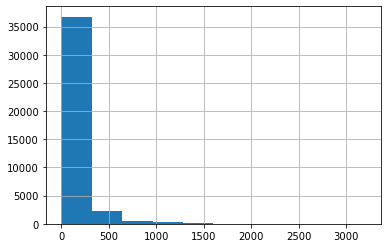

In [5]:
df['diff'].hist()
display(df['diff'].describe())

Видим, что присутствует максимальное значение = 3207 дней. Похоже на выброс. Проверим:

25-й перцентиль: 13.0, 75-й перцентиль: 122.4559933192162, IQR: 109.4559933192162,  Границы выбросов: [-151.18398997882431, 286.63998329804053].


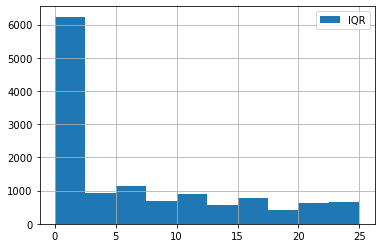

In [6]:
IQR = df['diff'].quantile(0.75) - df['diff'].quantile(0.25)
perc25 = df['diff'].quantile(0.25)
perc75 = df['diff'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25),
      '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                             l=perc75 + 1.5*IQR))

df['diff'].loc[df['diff'].between(perc25 - 1.5*IQR,
                                  perc75 + 1.5*IQR)].hist(bins=10,
                                                          range=(0, 25),
                                                          label='IQR')

plt.legend()

Получили выбросы выше 286 дней. 

In [7]:
# заменим выбросы на верхнюю границу + 1 (все что больше 286 дней)
df['diff'].values[df['diff'].values > (
    perc75 + 1.5*IQR)] = (perc75 + 1.5*IQR) + 1

count    40000.000000
mean        95.371572
std         91.321782
min          0.000000
25%         13.000000
50%         76.000000
75%        122.455993
max        287.639983
Name: diff, dtype: float64

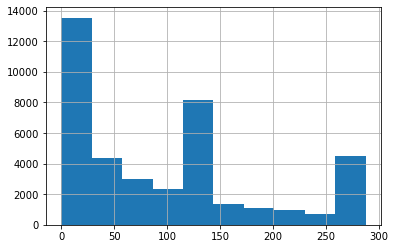

In [8]:
# проверяем

df['diff'].hist()
display(df['diff'].describe())

## Корреляционный анализ

Отбираем числовые столбцы для корреляционного анализа. Сюда не будем включать столбцы с городами и типом кухни, чтобы не загромождать анализ. Укажем только столбец с числом кухонь для каждого ресторана

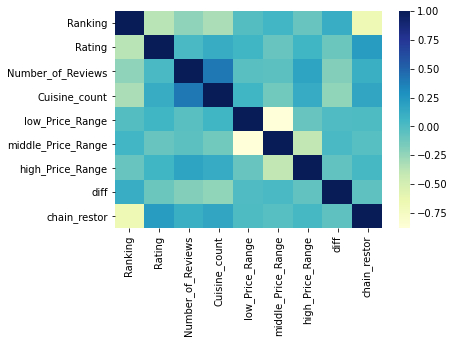

In [9]:
df1 = df[['Ranking','Rating','Number_of_Reviews','Cuisine_count',
          'low_Price_Range','middle_Price_Range','high_Price_Range','diff',
          'chain_restor']]

sns.heatmap(df1.corr(), cmap="YlGnBu")

In [10]:
df1.corr().min().sort_values()

low_Price_Range      -0.883652
middle_Price_Range   -0.883652
Ranking              -0.675937
chain_restor         -0.675937
high_Price_Range     -0.393300
Rating               -0.368371
Cuisine_count        -0.320250
diff                 -0.232201
Number_of_Reviews    -0.222072
dtype: float64

По матрице корреляции, а также по тепловой карте видно, что сильной прямой корреляции между разными данными нет (не считая переменных, которые коррелируют между собой же). С сильной обратной корреляцией можно заметить наиболее скоррелированные значения переменных **low_Price_Range** и **middle_Price_Range**, их значения корреляции составляют -0,8, можно убрать средний диапазон цен, оставив из диапазона цен только наиболее высокие цены (high_Price_Range) и наиболее низкие (low_Price_Range). 

In [11]:
# пробуем удалить столбцы 'middle_Price_Range'
df = df.drop(['middle_Price_Range'], axis=1)

Подготовим для обучения выборку, оставив лишь числовые столбцы. Переменные Rating и Restaurant_id оставляем, т.к. они будут удаляться позже при разбивке датафрейма. Уберем все номинативные столбцы:

In [12]:
'''готовим датафрейм для дальнейшего обучения'''
# находим все нечисловые столбцы, исключив Restaurant_id, он удалится позже
columns_list = df.drop(['Restaurant_id'], axis=1).select_dtypes(
    exclude='number').columns

# удаляем все нечисловые столбцы из датафрейма из списка columns_list
df = df.drop(columns_list, axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [13]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis=1)
y = df['Rating']

In [14]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [15]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [16]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [17]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [18]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2107615
